In [1]:
import numpy as np
import cvxpy as cp

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import pickle

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from models.ALISTA import ALISTA
from models.ALDCISTA import ALDC_ISTA

from utils.train import train, layerwise_train, layerwise_train_DC
from utils.synthetic_data import SyntheticSignals

In [3]:
n_ = 500
m_ = 250
p_ = 0.1

# Sensing matrix

torch.random.manual_seed(42)
A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Conditioning of the sensing matrix


In [5]:
def Conditioning(A, k = 1):
    U, S, Vh = torch.linalg.svd(A, full_matrices=False)
    S = torch.ones_like(S)
    S[-1] = 1/k

    return U @ torch.diag_embed(S) @ Vh

In [7]:
ks = [1,10,50,100,500,1000,5000]

conditioning_experiment = {k: {
    'ALISTA':None,
    'AL-DC-ISTA-EXP':None,
    'AL-DC-ISTA-PNEG':None,
    'AL-DC-ISTA-SCAD':None
} for k in ks}

n_ = 500
m_ = 250
p_ = 0.1

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

for k in tqdm(ks):
    B = Conditioning(torch.clone(A_), k)

    train_set = SyntheticSignals(
        A = B,
        n = n_,        
        m = m_,
        p = p_,
        SNR = None,
        size = 10000,
        batch_size = 1000
        ).set_loader()

    test_set = SyntheticSignals(
        A = B,
        n = n_,        
        m = m_,
        p = p_,
        SNR = None,
        size = 1000
        ).set_loader()
    
    model_1 = ALISTA(torch.clone(B), 0.4, T = 16)
    layerwise_train(model_1, train_set, test_set, 'ALISTA', lr = 3e-3, ft_lr = 3e-5, verbose=False)
    conditioning_experiment[k]['ALISTA'] = model_1.compute_nmse_inference(test_set)[-1].cpu()

    model_2 = ALDC_ISTA(torch.clone(B), 'EXP', 0.4, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
    layerwise_train_DC(model_2, train_set, test_set, 'AL-DC-ISTA', 'EXP', lr = 3e-3, ft_lr = 3e-5, verbose=False)
    conditioning_experiment[k]['AL-DC-ISTA-EXP'] = model_2.compute_nmse_inference(test_set)[-1].cpu()

    model_3 = ALDC_ISTA(torch.clone(B), 'PNEG', 0.4, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
    layerwise_train_DC(model_3, train_set, test_set, 'AL-DC-ISTA', 'PNEG', lr = 3e-3, ft_lr = 3e-5, verbose=False)
    conditioning_experiment[k]['AL-DC-ISTA-PNEG'] = model_3.compute_nmse_inference(test_set)[-1].cpu()

    model_4 = ALDC_ISTA(torch.clone(B), 'SCAD', 0.4, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
    layerwise_train_DC(model_4, train_set, test_set, 'AL-DC-ISTA', 'SCAD', lr = 3e-3, ft_lr = 3e-5, verbose=False)
    conditioning_experiment[k]['AL-DC-ISTA-SCAD'] = model_4.compute_nmse_inference(test_set)[-1].cpu()

  0%|          | 0/7 [00:00<?, ?it/s]

Linear layer initialized minimizing coherence!


 14%|█▍        | 1/7 [48:08<4:48:50, 2888.39s/it]

Linear layer initialized minimizing coherence!


 29%|██▊       | 2/7 [1:39:34<4:10:22, 3004.46s/it]

Linear layer initialized minimizing coherence!


 43%|████▎     | 3/7 [2:28:25<3:18:04, 2971.11s/it]

Linear layer initialized minimizing coherence!


 57%|█████▋    | 4/7 [3:15:00<2:25:04, 2901.55s/it]

Linear layer initialized minimizing coherence!


 71%|███████▏  | 5/7 [4:03:29<1:36:48, 2904.12s/it]

Linear layer initialized minimizing coherence!


 86%|████████▌ | 6/7 [4:52:50<48:43, 2923.45s/it]  

Linear layer initialized minimizing coherence!


100%|██████████| 7/7 [5:39:01<00:00, 2905.94s/it]


In [8]:
with open('conditioning_experiment.pkl', 'wb') as handle:
    pickle.dump(conditioning_experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

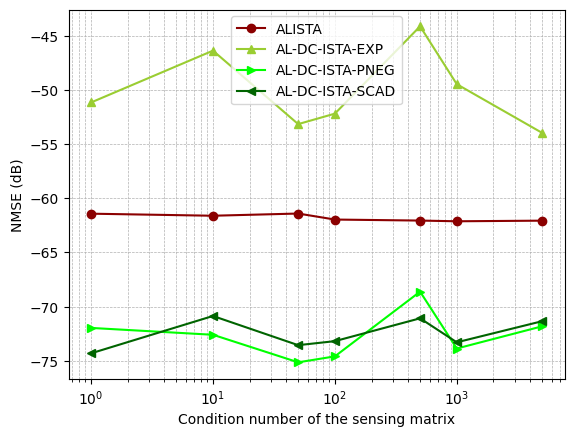

In [20]:
ks = [1,10,50,100,500,1000,5000]

models = [
    'ALISTA',
    'AL-DC-ISTA-EXP',
    'AL-DC-ISTA-PNEG',
    'AL-DC-ISTA-SCAD'
]

colors = [
    'darkred',
    'yellowgreen',
    'lime',
    'darkgreen'
]

markers = [
    'o',
    '^',
    '>',
    '<'
]
for i, model_ in enumerate(models):
    plt.plot(ks, [conditioning_experiment[k][model_] for k in ks], label = model_, color = colors[i], marker = markers[i])

plt.xticks(ks)

plt.ylabel('NMSE (dB)')
plt.xlabel('Condition number of the sensing matrix')
plt.xscale('log')

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# Reconstruction in noisy scenarios (noiseless training)

In [4]:
n_ = 500
m_ = 250
p_ = 0.1

torch.random.manual_seed(42)
A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = None,
        size = 10000,
        batch_size = 1000
        ).set_loader()

val_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = None,
        size = 1000
        ).set_loader()

model_1 = ALISTA(torch.clone(A_), 0.4, T = 16)
layerwise_train(model_1, train_set, val_set, 'ALISTA', lr = 3e-3, ft_lr = 3e-5, verbose=True)

model_2 = ALDC_ISTA(torch.clone(A_), 'EXP', 0.4, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_2, train_set, val_set, 'AL-DC-ISTA', 'EXP', lr = 3e-3, ft_lr = 3e-5, verbose=True)

model_3 = ALDC_ISTA(torch.clone(A_), 'PNEG', 0.4, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_3, train_set, val_set, 'AL-DC-ISTA', 'PNEG', lr = 3e-3, ft_lr = 3e-5, verbose=True)

model_4 = ALDC_ISTA(torch.clone(A_), 'SCAD', 0.4, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_4, train_set, val_set, 'AL-DC-ISTA', 'SCAD', lr = 3e-3, ft_lr = 3e-5, verbose=True)

Layer 14, Epoch 61/100, Train NMSE (dB): -57.597336, Validation NMSE (dB): -57.876015
Layer 14, Epoch 71/100, Train NMSE (dB): -57.597633, Validation NMSE (dB): -57.876099
Layer 14, Epoch 81/100, Train NMSE (dB): -57.597873, Validation NMSE (dB): -57.876935
Layer 14, Epoch 91/100, Train NMSE (dB): -57.598109, Validation NMSE (dB): -57.876884
Layer 14, Epoch 100/100, Train NMSE (dB): -57.598295, Validation NMSE (dB): -57.877030
===== Finished Training Layer 14/16 =====

===== Fine-Tuning the Entire Network =====
Fine-Tune Epoch 1/100, Train NMSE (dB): -57.474780, Validation NMSE (dB): -58.042357
Fine-Tune Epoch 11/100, Train NMSE (dB): -57.889837, Validation NMSE (dB): -58.069132
Fine-Tune Epoch 21/100, Train NMSE (dB): -57.873335, Validation NMSE (dB): -58.086450
Early stopping for fine-tuning triggered after 24 epochs
===== Finished Fine-Tuning =====

===== Training Layer 15/16 =====
Layer 15, Epoch 1/100, Train NMSE (dB): -34.143238, Validation NMSE (dB): -39.364416
Layer 15, Epoch 1

({'Layer_1': array([-1.47155166, -1.81077399, -2.0567572 , -2.28372753, -2.52681958,
         -2.76578576, -3.00004707, -3.23186607, -3.46243376, -3.69130029,
         -3.91674479, -4.13812811, -4.35477988, -4.56549643, -4.76960372,
         -4.96561936, -5.15223261, -5.3282036 , -5.49167507, -5.64169695,
         -5.77654964, -5.89531853, -5.99620498, -6.07829636, -6.14031857,
         -6.18240189, -6.20367878, -6.2066331 , -6.20693154, -6.20721302,
         -6.20718089, -6.20711597, -6.20737171, -6.20677297, -6.20694824,
         -6.2073427 , -6.20733827, -6.20707889, -6.20700502, -6.20728828,
         -6.20713104, -6.20725817, -6.20732918, -6.20742344, -6.20735886,
         -6.2073152 , -6.20717007, -6.20660172, -6.20721235, -6.20741473,
         -6.20733562, -6.20738342, -6.20740426]),
  'Fine_Tune': array([-57.84281923, -57.61596444, -59.24066839, -59.46163388,
         -59.64853524, -59.71712212, -59.69203807, -59.73121337,
         -59.75788987, -59.75473859, -59.77176496, -59.7

In [5]:
torch.save(model_1.state_dict(), "model_1_NOISELESS_weights.pth")
torch.save(model_2.state_dict(), "model_2_NOISELESS_weights.pth")
torch.save(model_3.state_dict(), "model_3_NOISELESS_weights.pth")
torch.save(model_4.state_dict(), "model_4_NOISELESS_weights.pth")

In [6]:
SNRs = [1] + list(range(5,81,5))
n_ = 500
m_ = 250
p_ = 0.1 

noisy_scenarios = {SNR: {
    'ALISTA':None,
    'AL-DC-ISTA-EXP':None,
    'AL-DC-ISTA-PNEG':None,
    'AL-DC-ISTA-SCAD':None
} for SNR in SNRs}

In [7]:
for SNR_ in tqdm(SNRs):
    
    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 10**(SNR_/10),
        size = 1000
        ).set_loader()

    noisy_scenarios[SNR_]['ALISTA'] = model_1.compute_nmse_inference(test_set)[-1].cpu()
    noisy_scenarios[SNR_]['AL-DC-ISTA-EXP'] = model_2.compute_nmse_inference(test_set)[-1].cpu()
    noisy_scenarios[SNR_]['AL-DC-ISTA-PNEG'] = model_3.compute_nmse_inference(test_set)[-1].cpu()
    noisy_scenarios[SNR_]['AL-DC-ISTA-SCAD'] = model_4.compute_nmse_inference(test_set)[-1].cpu()

100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


In [8]:
with open('noisy_noiseless_scenarios.pkl', 'wb') as handle:
    pickle.dump(noisy_scenarios, handle, protocol=pickle.HIGHEST_PROTOCOL)

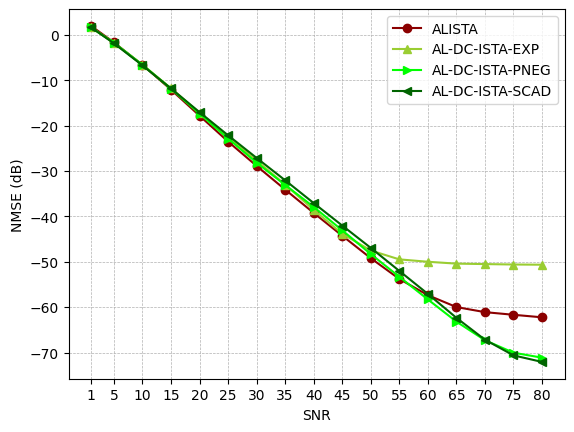

In [9]:
models = [
    'ALISTA',
    'AL-DC-ISTA-EXP',
    'AL-DC-ISTA-PNEG',
    'AL-DC-ISTA-SCAD'
]

colors = [
    'darkred',
    'yellowgreen',
    'lime',
    'darkgreen'
]

markers = [
    'o',
    '^',
    '>',
    '<'
]
for i, model_ in enumerate(models):
    plt.plot(SNRs, [noisy_scenarios[SNR_][model_] for SNR_ in SNRs], label = model_, color = colors[i], marker = markers[i])

plt.xticks(SNRs)

plt.ylabel('NMSE (dB)')
plt.xlabel('SNR')

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# Probability of correct support selection 

In [ ]:
n_ = 500
m_ = 250
p_ = 0.2

torch.random.manual_seed(42)
A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = None,
        size = 10000,
        batch_size = 1000
        ).set_loader()

val_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = None,
        size = 1000
        ).set_loader()

model_1 = ALISTA(torch.clone(A_), 0.4, T = 32)
layerwise_train(model_1, train_set, val_set, 'ALISTA', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_2 = ALDC_ISTA(torch.clone(A_), 'EXP', 0.4, T = 32, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_2, train_set, val_set, 'AL-DC-ISTA', 'EXP', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_3 = ALDC_ISTA(torch.clone(A_), 'PNEG', 0.4, T = 32, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_3, train_set, val_set, 'AL-DC-ISTA', 'PNEG', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_4 = ALDC_ISTA(torch.clone(A_), 'SCAD', 0.4, T = 32, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_4, train_set, val_set, 'AL-DC-ISTA', 'SCAD', lr = 3e-3, ft_lr = 3e-5, verbose=False)

In [12]:
torch.save(model_1.state_dict(), "model_1_SUPPORT_weights.pth")
torch.save(model_2.state_dict(), "model_1_SUPPORT_weights.pth")
torch.save(model_3.state_dict(), "model_1_SUPPORT_weights.pth")
torch.save(model_4.state_dict(), "model_1_SUPPORT_weights.pth")

In [161]:
ps = np.arange(0.01,0.5,0.01)

In [173]:
precisions_1 = {p:0 for p in ps}
precisions_2 = {p:0 for p in ps}
precisions_3 = {p:0 for p in ps}
precisions_4 = {p:0 for p in ps}

In [163]:
def compute_support(model, test_loader):

    total_precision = 0.0
    total_samples = 0

    # Iterate over test_loader
    for _, (Y, S) in enumerate(test_loader):
        Y, S = Y.to(model.device), S.to(model.device)
        X = model.forward(y=Y, its=None)

        # Create binary support masks for X and S
        X_thresholded = (X != 0).float() # Predicted support
        S_support = (S != 0).float()  # Ground truth support

        # True positives: Correctly identified non-zero elements
        true_positives = (X_thresholded * S_support).sum(dim=1)

        # Predicted positives: All non-zero elements in X_thresholded
        predicted_positives = X_thresholded.sum(dim=1)

        # Precision: True positives / Predicted positives (avoid division by zero)
        precision = true_positives / (predicted_positives + 1e-10)

        # Accumulate total precision
        total_precision += precision.sum().item()
        total_samples += Y.size(0)

    # Compute the average precision over all batches
    average_precision = total_precision / total_samples

    return average_precision


In [164]:
for _ in tqdm(range(10)):
    for p in ps:
        test_set = SyntheticSignals(
          A = A_,
          n = n_,
          m = m_,
          p = p,
          SNR = None,
          size = 1000,
          discretized = True
          ).set_loader()

        precisions_1[p] += compute_support(model_1, test_set)
        precisions_2[p] += compute_support(model_2, test_set)
        precisions_3[p] += compute_support(model_3, test_set)
        precisions_4[p] += compute_support(model_4, test_set)

100%|██████████| 10/10 [04:53<00:00, 29.32s/it]


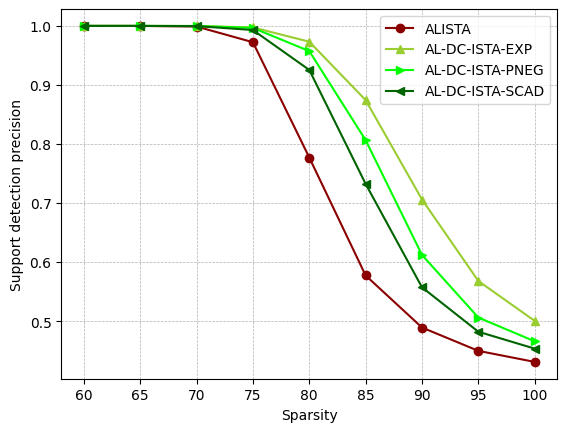

In [172]:
models = [
    'ALISTA',
    'AL-DC-ISTA-EXP',
    'AL-DC-ISTA-PNEG',
    'AL-DC-ISTA-SCAD'
]

colors = [
    'darkred',
    'yellowgreen',
    'lime',
    'darkgreen'
]

markers = [
    'o',
    '^',
    '>',
    '<'
]

precisions = {
    'ALISTA':[precisions_1[p] / 10 for p in ps],
    'AL-DC-ISTA-EXP':[precisions_2[p] / 10 for p in ps],
    'AL-DC-ISTA-PNEG':[precisions_3[p] / 10 for p in ps],
    'AL-DC-ISTA-SCAD':[precisions_4[p] / 10 for p in ps]
}

for i, model_ in enumerate(models):
    plt.plot([int(p*500) for p in ps][11:20], precisions[model_][11:20], label = model_, color = colors[i], marker = markers[i])


plt.xlabel('Sparsity')
plt.ylabel('Support detection precision')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()